In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


import scipy.interpolate as interp

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
from keras import metrics
import keras_metrics as km
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt
import pathlib 
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
#gpu configuration:

gpu_num = 1

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")


2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


In [6]:
import os
file_path = os.path.join('/home/smith26/public_html/el-nseos-mll', 'preprocessing.csv') #imports file from directory
df = pd.read_csv(file_path, index_col = 0) #makes sure columns stay as they are
df

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      1.704363  0.940013  1.686090  3.498810  2.749811  35.365482  4.163723   
1      0.674195  0.488352  4.630310  5.249203  3.595422  34.654207  3.981949   
2      1.944506  1.625537  2.224806  2.701013  3.520350  35.396764  4.952541   
3      0.582582  0.362044  4.685642  5.651456  2.917128  35.255684  1.149857   
4      2.684166  2.462512  1.709042  1.964290  4.252634  34.932686  3.321473   
...         ...       ...       ...       ...       ...        ...       ...   
49995  1.093111  0.866491  1.965994  2.528221  3.791754  33.440527  4.773079   
49996  0.450100  0.421913  3.340404  4.616534  2.362006  33.940821  2.777913   
49997  1.229125  0.916376  2.503452  3.099723  3.293796  33.026767  4.130634   
49998  0.884386  0.667397  2.974374  5.247997  4.598794  35.306336  3.806648   
49999  2.689961  0.624463  3.588572  4.208695  4.750452  34.792232  4.234088   

       logp2_cgs    gamma2  
0      35.765971  1.138051  
1      34.993765  1.593887  
2      36.017062  1.272790  
3      36.029744  1.967677  
4      35.708051  1.456522  
...          ...       ...  
49995  36.900283  1.091320  
49996  34.595926  1.535013  
49997  34.994576  2.092221  
49998  35.632485  1.049226  
49999  35.206430  1.144645  

[50000 rows x 9 columns]

normeddata = pd.DataFrame().reindex(columns=df.columns)
normeddata

In [10]:
normeddata = df.copy(deep = True ) #making a copy to normalize the data - makes it easier all in all
normeddata

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      1.704363  0.940013  1.686090  3.498810  2.749811  35.365482  4.163723   
1      0.674195  0.488352  4.630310  5.249203  3.595422  34.654207  3.981949   
2      1.944506  1.625537  2.224806  2.701013  3.520350  35.396764  4.952541   
3      0.582582  0.362044  4.685642  5.651456  2.917128  35.255684  1.149857   
4      2.684166  2.462512  1.709042  1.964290  4.252634  34.932686  3.321473   
...         ...       ...       ...       ...       ...        ...       ...   
49995  1.093111  0.866491  1.965994  2.528221  3.791754  33.440527  4.773079   
49996  0.450100  0.421913  3.340404  4.616534  2.362006  33.940821  2.777913   
49997  1.229125  0.916376  2.503452  3.099723  3.293796  33.026767  4.130634   
49998  0.884386  0.667397  2.974374  5.247997  4.598794  35.306336  3.806648   
49999  2.689961  0.624463  3.588572  4.208695  4.750452  34.792232  4.234088   

       logp2_cgs    gamma2  
0      35.765971  1.138051  
1      34.993765  1.593887  
2      36.017062  1.272790  
3      36.029744  1.967677  
4      35.708051  1.456522  
...          ...       ...  
49995  36.900283  1.091320  
49996  34.595926  1.535013  
49997  34.994576  2.092221  
49998  35.632485  1.049226  
49999  35.206430  1.144645  

[50000 rows x 9 columns]

In [11]:
def normalizeandwhiten(x):
    gamma0_norm = (x['gamma0'] - 1) / (5 - 1)
    gamma1_norm = (x['gamma1'] - 1) / (5 - 1)
    gamma2_norm = (x['gamma2'] - 1) / (5 - 1)
    #normalizating p values
    logp1_cgs_norm = (x['logp1_cgs'] - 33) / (37 - 33)
    logp2_cgs_norm = (x['logp2_cgs'] - 33) / (37 - 33)
    return gamma0_norm, logp1_cgs_norm, gamma1_norm, logp2_cgs_norm, gamma2_norm
#print(gamma0_norm)
# Call the function and save the normalized values to 'normeddata'
normeddata['gamma0'], normeddata['logp1_cgs'], normeddata['gamma1'], normeddata['logp2_cgs'], normeddata['gamma2'] = normalizeandwhiten(normeddata)

In [12]:
normeddata

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      1.704363  0.940013  1.686090  3.498810  0.437453   0.591370  0.790931   
1      0.674195  0.488352  4.630310  5.249203  0.648856   0.413552  0.745487   
2      1.944506  1.625537  2.224806  2.701013  0.630087   0.599191  0.988135   
3      0.582582  0.362044  4.685642  5.651456  0.479282   0.563921  0.037464   
4      2.684166  2.462512  1.709042  1.964290  0.813159   0.483171  0.580368   
...         ...       ...       ...       ...       ...        ...       ...   
49995  1.093111  0.866491  1.965994  2.528221  0.697939   0.110132  0.943270   
49996  0.450100  0.421913  3.340404  4.616534  0.340501   0.235205  0.444478   
49997  1.229125  0.916376  2.503452  3.099723  0.573449   0.006692  0.782659   
49998  0.884386  0.667397  2.974374  5.247997  0.899699   0.576584  0.701662   
49999  2.689961  0.624463  3.588572  4.208695  0.937613   0.448058  0.808522   

       logp2_cgs    gamma2  
0       0.691493  0.034513  
1       0.498441  0.148472  
2       0.754266  0.068198  
3       0.757436  0.241919  
4       0.677013  0.114131  
...          ...       ...  
49995   0.975071  0.022830  
49996   0.398982  0.133753  
49997   0.498644  0.273055  
49998   0.658121  0.012307  
49999   0.551607  0.036161  

[50000 rows x 9 columns]

m1norm  = (df['m1'] - df['m1'].mean())/ df['m1'].std()
print(m1norm)

In [92]:
m1norm = (df['m1'] - df['m1'].min())/ (df['m1'].max()-df['m1'].min())
m2norm = (df['m2'] - df['m2'].min())/ (df['m2'].max()-df['m2'].min())
l1norm = (df['l1'] - df['l1'].min())/ (df['l1'].max()-df['l1'].min())
l2norm = (df['l2'] - df['l2'].min())/ (df['l2'].max()-df['l2'].min())
normeddata['m1'] = m1norm
normeddata['m2'] = m2norm
normeddata['l1'] = l1norm
normeddata['l2'] = l2norm 
normeddata

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
0      0.365400  0.173741  0.279635  0.543609  0.437453   0.591370  0.790931   
1      0.098087  0.054358  0.765004  0.846278  0.648856   0.413552  0.745487   
2      0.427714  0.354939  0.368445  0.405658  0.630087   0.599191  0.988135   
3      0.074315  0.020973  0.774126  0.915834  0.479282   0.563921  0.037464   
4      0.619644  0.576167  0.283419  0.278268  0.813159   0.483171  0.580368   
...         ...       ...       ...       ...       ...        ...       ...   
49995  0.206790  0.154308  0.325778  0.375780  0.697939   0.110132  0.943270   
49996  0.039938  0.036797  0.552357  0.736880  0.340501   0.235205  0.444478   
49997  0.242083  0.167493  0.414381  0.474601  0.573449   0.006692  0.782659   
49998  0.152629  0.101683  0.492015  0.846070  0.899699   0.576584  0.701662   
49999  0.621148  0.090335  0.593269  0.666359  0.937613   0.448058  0.808522   

       logp2_cgs    gamma2  
0       0.691493  0.034513  
1       0.498441  0.148472  
2       0.754266  0.068198  
3       0.757436  0.241919  
4       0.677013  0.114131  
...          ...       ...  
49995   0.975071  0.022830  
49996   0.398982  0.133753  
49997   0.498644  0.273055  
49998   0.658121  0.012307  
49999   0.551607  0.036161  

[50000 rows x 9 columns]

m1norm = df['m1']

m1norm = (df['m1'] - df['m1'].min())/(df['m1'].max()-df['m1'].min())
m2norm = (df['m2'] - df['m2'].min())/(df['m2'].max()-df['m2'].min())
l1norm = (df['l1'] - df['l1'].min())/(df['l1'].max()-df['l1'].min())
l2norm = (df['l2'] - df['l2'].min())/(df['l2'].max()-df['l2'].min())
normeddata['m1'] = m1norm
normeddata['m2'] = m2norm
normeddata['l1'] = l1norm
normeddata['l2'] = l2norm 
normeddata

def whiteninput(x,y):
    m1norm = (x['y'] - x['y'].mean())/x['y'].std()
    return m1norm
print(whiteninput(df, ['m1']))

In [93]:
train_dataset = normeddata.sample(frac=0.8, random_state=1)
test_dataset = normeddata.drop(train_dataset.index)

In [94]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [95]:
train_copy = train_dataset.copy()
test_copy = test_dataset.copy()

In [96]:
train_copy

m1        m2        l1        l2    gamma0  logp1_cgs    gamma1  \
26247  0.551008  0.414413  0.615342  0.879623  0.551260   0.476077  0.902952   
35067  0.167412  0.099230  0.213292  0.465095  0.238925   0.376316  0.396880   
34590  0.341859  0.228158  0.331559  0.478942  0.805927   0.122036  0.493166   
16668  0.135887  0.108581  0.378482  0.359480  0.790035   0.100956  0.173479   
12196  0.292646  0.041346  0.590697  0.823584  0.884590   0.347262  0.032326   
...         ...       ...       ...       ...       ...        ...       ...   
35831  0.463285  0.448553  0.735608  0.745110  0.765890   0.264151  0.418364   
19038  0.337634  0.076837  0.235644  0.348570  0.665590   0.191839  0.802925   
42576  0.594670  0.570577  0.492819  0.937027  0.488299   0.265630  0.779981   
39791  0.719158  0.550912  0.401376  0.493655  0.915903   0.909726  0.109302   
11710  0.616123  0.047999  0.593450  0.790796  0.583749   0.013108  0.843367   

       logp2_cgs    gamma2  
26247   0.767194  0.170218  
35067   0.772996  0.078704  
34590   0.810399  0.025027  
16668   0.412126  0.262980  
12196   0.403833  0.002985  
...          ...       ...  
35831   0.555530  0.314703  
19038   0.455596  0.221671  
42576   0.871145  0.066923  
39791   0.938047  0.214776  
11710   0.550061  0.146111  

[40000 rows x 9 columns]

In [139]:
train_label = train_copy.drop(columns = ['m1', 'm2', 'l1', 'l2', 'gamma1', 'logp1_cgs', 'logp2_cgs', 'gamma2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 large training
test_label = test_copy.drop(columns = ['m1', 'm2', 'l1', 'l2', 'gamma1', 'logp1_cgs', 'logp2_cgs', 'gamma2']) #pandas with gamma0, gamma1, logp1, logp2, gamma2 small testing

train_features = train_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1, m2, l1,l2 large
test_features = test_copy.drop(columns = ['gamma0', 'gamma1', 'gamma2', 'logp1_cgs', 'logp2_cgs']) #m1,m2,l1,l2 small


In [140]:
train_features

m1        m2        l1        l2
26247  0.551008  0.414413  0.615342  0.879623
35067  0.167412  0.099230  0.213292  0.465095
34590  0.341859  0.228158  0.331559  0.478942
16668  0.135887  0.108581  0.378482  0.359480
12196  0.292646  0.041346  0.590697  0.823584
...         ...       ...       ...       ...
35831  0.463285  0.448553  0.735608  0.745110
19038  0.337634  0.076837  0.235644  0.348570
42576  0.594670  0.570577  0.492819  0.937027
39791  0.719158  0.550912  0.401376  0.493655
11710  0.616123  0.047999  0.593450  0.790796

[40000 rows x 4 columns]

In [141]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten, Dense, ReLU
from keras.layers import BatchNormalization, LayerNormalization
from keras import regularizers

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperParameters, BayesianOptimization
from keras.regularizers import l2
import keras_tuner
import keras


In [142]:
#custom objective function
#def rmse(y_true, y_pred):
    #return np.sqrt(((y_true - y_targ) ** 2).mean())

In [143]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                 patience=80,
                                 min_delta=0.001, 
                                 mode='auto') 

In [166]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout =0.5), input_shape=(4, 1))
)
model.add(layers.Bidirectional(layers.LSTM(32, dropout = 0.5)))
model.add(layers.Dense(1))
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.003),#, amsgrad = True),
              loss =  'cosine_similarity', metrics =['mae', tf.keras.metrics.RootMeanSquaredError(
    name='huber', dtype=None
)])
history = model.fit(train_features, train_label, epochs = 10, verbose =1, validation_split = .2, callbacks = [callback])

Epoch 1/10


/home/smith26/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - huber: 0.5219 - loss: -0.9911 - mae: 0.4694 - val_huber: 0.5513 - val_loss: -1.0000 - val_mae: 0.5004
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - huber: 0.6347 - loss: -0.5889 - mae: 0.5739 - val_huber: 0.9686 - val_loss: 0.9937 - val_mae: 0.9254
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - huber: 1.0306 - loss: 0.5061 - mae: 0.9407 - val_huber: 1.0825 - val_loss: 0.9992 - val_mae: 1.0396
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - huber: 1.1282 - loss: 0.5017 - mae: 1.0263 - val_huber: 1.1666 - val_loss: 0.9998 - val_mae: 1.1239
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - huber: 1.2270 - loss: 0.4964 - mae: 1.1132 - val_huber: 1.2643 - val_loss: 1.0000 - val_mae: 1.2212
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - huber: 1.3331 - loss: 0.4967 - mae: 1.2054 - val_huber: 1.3877 - val_loss: 1.0000 - val_mae: 1.3437
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - hu

model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(4, 1))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1))
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.003),#, amsgrad = True),
              loss =  'mse', metrics =['mae', tf.keras.metrics.RootMeanSquaredError(
    name='rmse', dtype=None
)])
history = model.fit(train_features, train_label, epochs = 40, verbose =1, validation_split = .2, batch_size =64, callbacks = [callback])

model = Sequential([
    layers.Input(shape= (4,1)),
    #layers.BatchNormalization(),
    layers.Conv1D(filters = 63, kernel_size = 3, padding = 'same'), 
    layers.ReLU(max_value = None, negative_slope=0.0, threshold=0.0),
    #layers.Dropout(0.5),
    #layers.LayerNormalization(),
    layers.GlobalMaxPooling1D(),
    layers.Dense(26, activation = 'leaky_relu'),#, kernel_regularizer=regularizers.l2(0.001)),
    #layers.Flatten(),
    layers.Dense(1, activation = 'gelu')
])

model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.1),#, amsgrad = True),
              loss =  'mse', metrics =['mae', tf.keras.metrics.RootMeanSquaredError(
    name='ajha', dtype=None
)])

history = model.fit(train_features, train_label, epochs = 100, verbose =1, validation_split = .2, batch_size =8, callbacks = [callback])

model = Sequential()
model.add(normalizer())
model.add(Conv1D(filters = 16, kernel_size = 3, activation = 'relu', input_shape = (4,1)))
model.add(LayerNormalization()


\)
model.add(GlobalMaxPooling1D())
#model.add(Flatten())
model.add(Dense(128, activation = 'relu'))#, kernel_regularizer = keras.regularizers.L2(0.0001)))
model.add(Dense(1))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0015, clipnorm =1), #, use_ema =True, amsgrad = True),
              loss = 'cosine_similarity', metrics =['mae'])

history = model.fit(train_features, train_label, epochs = 400, verbose =1)#, callbacks = callback)

In [167]:
test_predictions = model.predict(train_features)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step


In [168]:
print(test_predictions)

[[-1.677]
 [-0.529]
 [-0.885]
 ...
 [-1.761]
 [-1.464]
 [-1.386]]


In [169]:
lab_max = normeddata['gamma0'].max()
lab_min = normeddata['gamma0'].min()
lab_range = lab_max - lab_min
lab_mean = normeddata['gamma0'].mean()
print(lab_max, lab_min, lab_range, lab_mean)

0.99999834196278 7.982410285611863e-05 0.9999185178599239 0.6411786126206468


In [170]:
pred_max = test_predictions[:, [0]].max()
pred_min = test_predictions[:, [0]].min()
pred_range = pred_max - pred_min
pred_mean = test_predictions[:, [0]].mean()
print(pred_max, pred_min, pred_range, pred_mean)

0.15003765 -2.2529812 2.403019 -1.0575621


In [171]:
predictions_array_length = 40000
numcols = 10
array_sizes =  np.array([[0] * numcols ] * predictions_array_length,dtype='float64')
predictions = pd.DataFrame(array_sizes)
predictions.columns = [ 'gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted', 'gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted','logp2_cgs_predicted', 'gamma2_predicted']

predictions['gamma0_norm_predicted'] = test_predictions[:, [0]]
predictions['logp1_cgs_norm_predicted'] = test_predictions[:, [1]]
predictions['gamma1_norm_predicted'] = test_predictions[:, [2]]
predictions['logp2_cgs_norm_predicted'] = test_predictions[:, [3]]
predictions['gamma2_norm_predicted'] = test_predictions[:, [4]]
predictions['gamma0_predicted'] = test_predictions[:, [0]] * (5 - 1) + 1
predictions['logp1_cgs_predicted'] = test_predictions[:, [1]] *  (37 - 33) + 33
predictions['gamma1_predicted'] = test_predictions[:, [2]] * (5 - 1) + 1
predictions['logp2_cgs_predicted'] = test_predictions[:, [3]] *  (37 - 33) + 33
predictions['gamma2_predicted'] = test_predictions[:, [4]] * (5 - 1) + 1
predictions

import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color,range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color,range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color,range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('predicting one output, cosine sim', fontsize=20)
plt.show()

import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color,range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color,range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color,range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('predicting one output, cosine sim', fontsize=20)
plt.show()

In [172]:
predictions['gamma0_norm_predicted'] = test_predictions[:, [0]]
#predictions['logp1_cgs_norm_predicted'] = test_predictions[:, [1]]
#predictions['gamma1_norm_predicted'] = test_predictions[:, [2]]
#predictions['logp2_cgs_norm_predicted'] = test_predictions[:, [3]]
#predictions['gamma2_norm_predicted'] = test_predictions[:, [4]]
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                  -1.677484                       0.0                    0.0   
1                  -0.529500                       0.0                    0.0   
2                  -0.885422                       0.0                    0.0   
3                  -0.568795                       0.0                    0.0   
4                  -1.178080                       0.0                    0.0   
...                      ...                       ...                    ...   
39995              -1.639325                       0.0                    0.0   
39996              -0.565404                       0.0                    0.0   
39997              -1.761402                       0.0                    0.0   
39998              -1.463992                       0.0                    0.0   
39999              -1.386009                       0.0                    0.0   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                           0.0                    0.0               0.0   
1                           0.0                    0.0               0.0   
2                           0.0                    0.0               0.0   
3                           0.0                    0.0               0.0   
4                           0.0                    0.0               0.0   
...                         ...                    ...               ...   
39995                       0.0                    0.0               0.0   
39996                       0.0                    0.0               0.0   
39997                       0.0                    0.0               0.0   
39998                       0.0                    0.0               0.0   
39999                       0.0                    0.0               0.0   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                      0.0               0.0                  0.0   
1                      0.0               0.0                  0.0   
2                      0.0               0.0                  0.0   
3                      0.0               0.0                  0.0   
4                      0.0               0.0                  0.0   
...                    ...               ...                  ...   
39995                  0.0               0.0                  0.0   
39996                  0.0               0.0                  0.0   
39997                  0.0               0.0                  0.0   
39998                  0.0               0.0                  0.0   
39999                  0.0               0.0                  0.0   

       gamma2_predicted  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
39995               0.0  
39996               0.0  
39997               0.0  
39998               0.0  
39999               0.0  

[40000 rows x 10 columns]

In [173]:
predictions['gamma0_predicted'] = test_predictions[:, [0]] * (5 - 1) + 1
#predictions['logp1_cgs_predicted'] = test_predictions[:, [1]] *  (37 - 33) + 33
#predictions['gamma1_predicted'] = test_predictions[:, [2]] * (5 - 1) + 1
#predictions['logp2_cgs_predicted'] = test_predictions[:, [3]] *  (37 - 33) + 33
#predictions['gamma2_predicted'] = test_predictions[:, [4]] * (5 - 1) + 1
predictions

gamma0_norm_predicted  logp1_cgs_norm_predicted  gamma1_norm_predicted  \
0                  -1.677484                       0.0                    0.0   
1                  -0.529500                       0.0                    0.0   
2                  -0.885422                       0.0                    0.0   
3                  -0.568795                       0.0                    0.0   
4                  -1.178080                       0.0                    0.0   
...                      ...                       ...                    ...   
39995              -1.639325                       0.0                    0.0   
39996              -0.565404                       0.0                    0.0   
39997              -1.761402                       0.0                    0.0   
39998              -1.463992                       0.0                    0.0   
39999              -1.386009                       0.0                    0.0   

       logp2_cgs_norm_predicted  gamma2_norm_predicted  gamma0_predicted  \
0                           0.0                    0.0         -5.709935   
1                           0.0                    0.0         -1.117999   
2                           0.0                    0.0         -2.541688   
3                           0.0                    0.0         -1.275180   
4                           0.0                    0.0         -3.712319   
...                         ...                    ...               ...   
39995                       0.0                    0.0         -5.557301   
39996                       0.0                    0.0         -1.261616   
39997                       0.0                    0.0         -6.045609   
39998                       0.0                    0.0         -4.855969   
39999                       0.0                    0.0         -4.544034   

       logp1_cgs_predicted  gamma1_predicted  logp2_cgs_predicted  \
0                      0.0               0.0                  0.0   
1                      0.0               0.0                  0.0   
2                      0.0               0.0                  0.0   
3                      0.0               0.0                  0.0   
4                      0.0               0.0                  0.0   
...                    ...               ...                  ...   
39995                  0.0               0.0                  0.0   
39996                  0.0               0.0                  0.0   
39997                  0.0               0.0                  0.0   
39998                  0.0               0.0                  0.0   
39999                  0.0               0.0                  0.0   

       gamma2_predicted  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
39995               0.0  
39996               0.0  
39997               0.0  
39998               0.0  
39999               0.0  

[40000 rows x 10 columns]

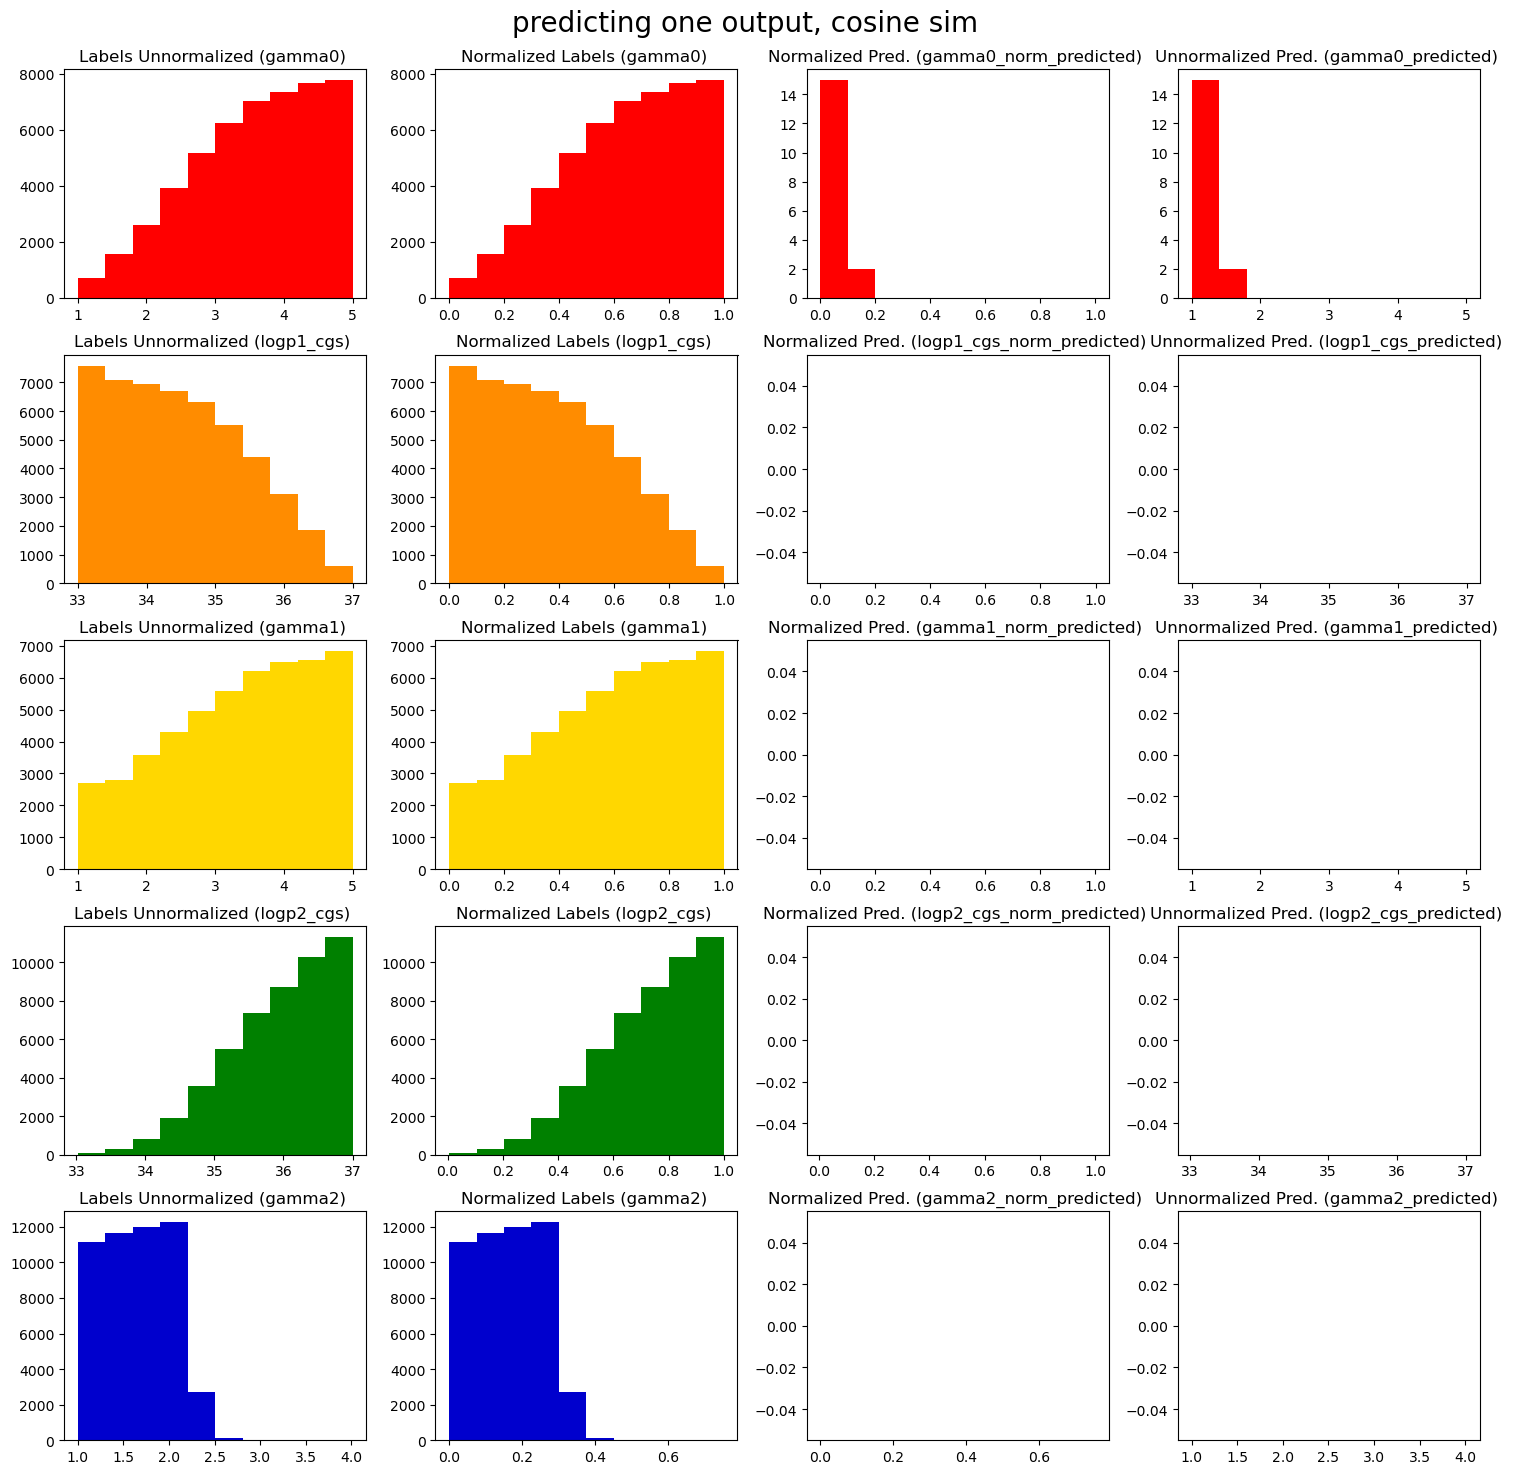

In [174]:
import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color, range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color, range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('predicting one output, cosine sim', fontsize=20)
plt.show()

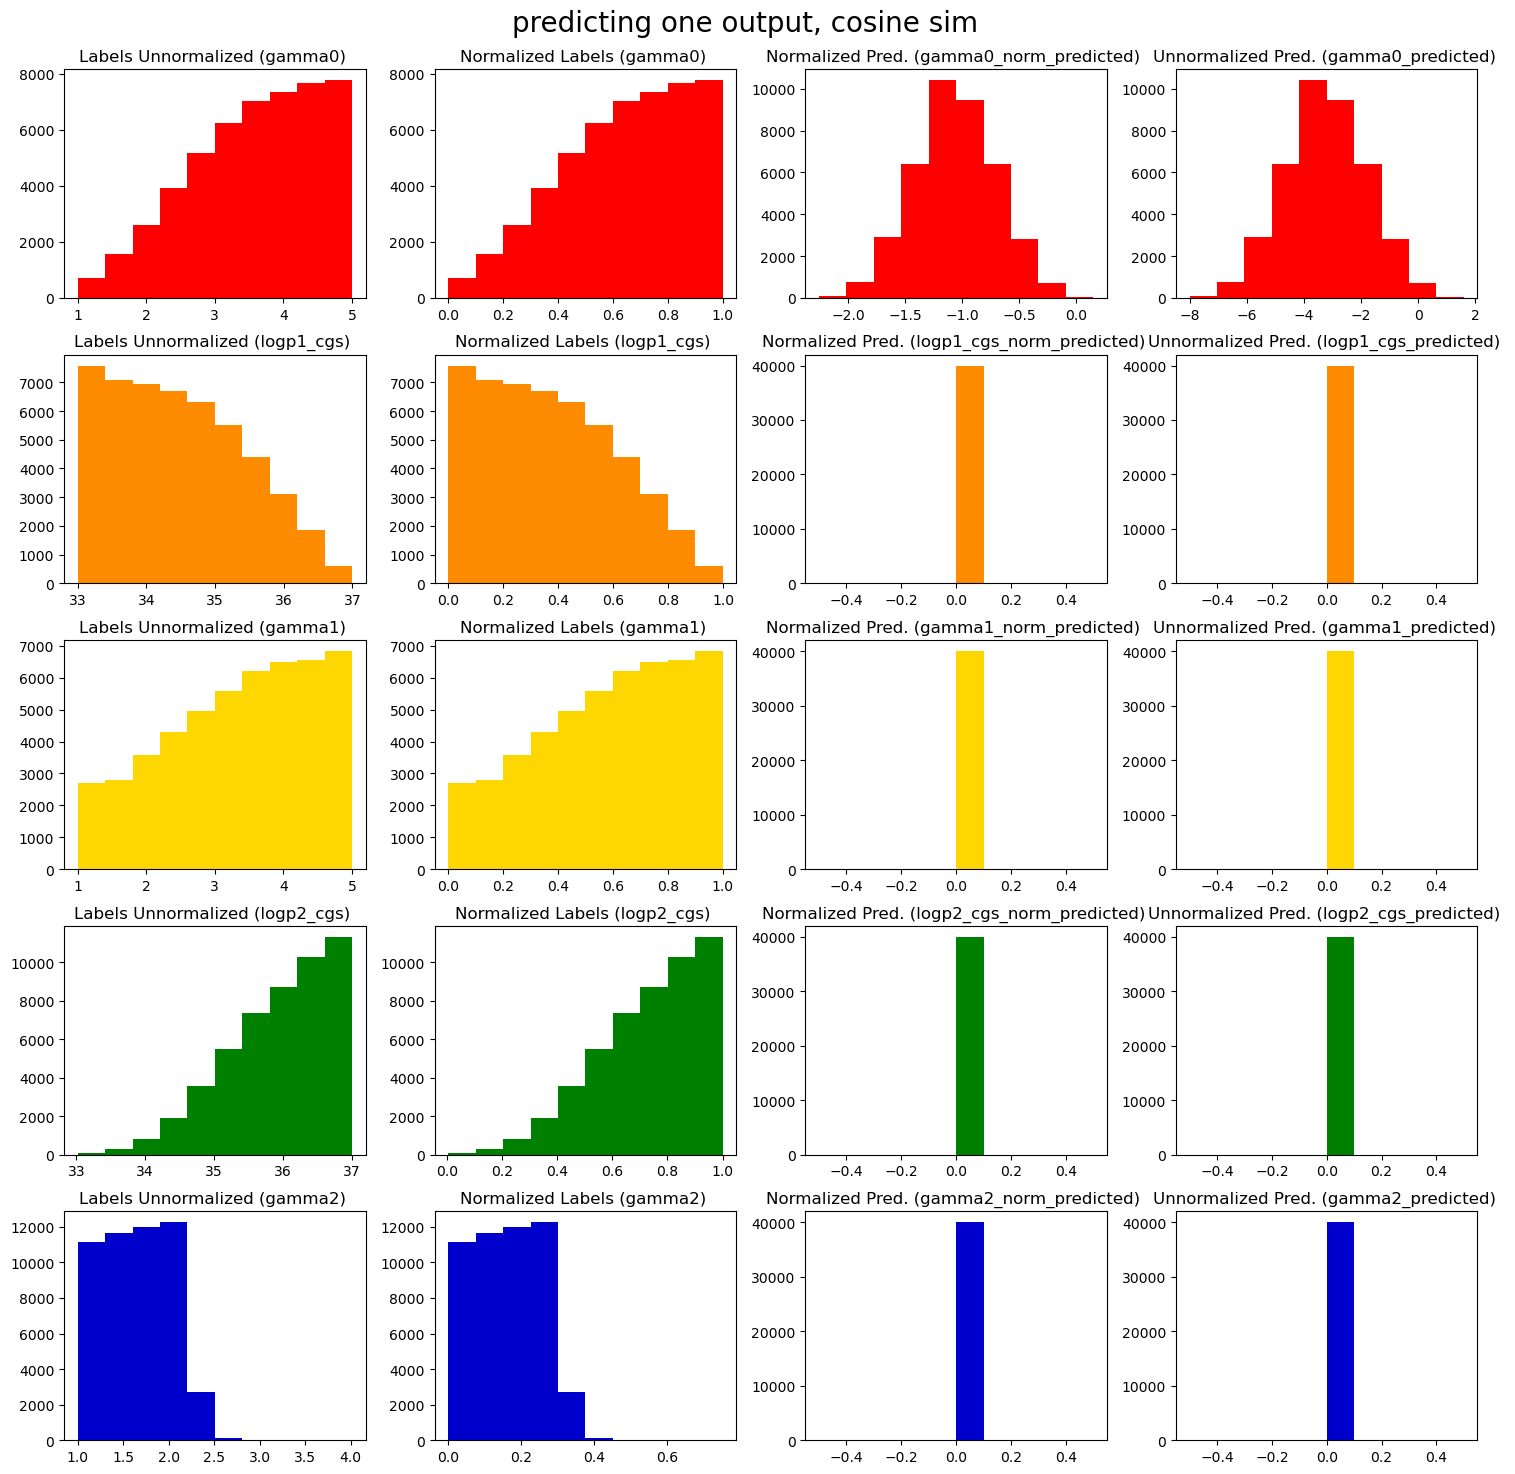

In [175]:
import numpy as np
import matplotlib.pyplot as plt

labels_cols = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']
norm_labels = ['gamma0', 'logp1_cgs', 'gamma1', 'logp2_cgs', 'gamma2']

norm_predictions = ['gamma0_norm_predicted', 'logp1_cgs_norm_predicted', 'gamma1_norm_predicted', 'logp2_cgs_norm_predicted', 'gamma2_norm_predicted']
predictions_cols = ['gamma0_predicted', 'logp1_cgs_predicted', 'gamma1_predicted', 'logp2_cgs_predicted', 'gamma2_predicted']


labels = [df[col].to_numpy() for col in labels_cols]
normlabel = [normeddata[col].to_numpy() for col in norm_labels]

normpredictions = [predictions[col].to_numpy() for col in norm_predictions]
prediction = [predictions[col].to_numpy() for col in predictions_cols]


fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        if j == 0:  #first column i want to be gamma0_labels
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(labels[i], color=color)#, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Labels Unnormalized ({labels_cols[i]}) ")
            
        elif j == 1:  #second column should be the gamm0 predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normlabel[i], color=color) #range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Labels ({norm_labels[i]}) ")
    
          
        elif j == 2:  #3rd column should be the norm labels 
            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(normpredictions[i], color=color)#, range=(np.min(normlabel[i]), np.max(normlabel[i])))
            axs[i, j].set_title(f"Normalized Pred. ({norm_predictions[i]}) ")
            
        
        elif j == 3: # 4th column should be the norm predictions

            color = 'red' if i == 0 else 'darkorange' if i == 1 else 'gold' if i == 2 else 'green' if i == 3 else 'mediumblue'
            axs[i, j].hist(prediction[i], color=color)#, range=(np.min(labels[i]), np.max(labels[i])))
            axs[i, j].set_title(f"Unnormalized Pred. ({predictions_cols[i]}) ")

plt.tight_layout()
plt.subplots_adjust(top=.94) 
fig.suptitle('predicting one output, cosine sim', fontsize=20)
plt.show()